In [18]:
import os

# Встановлюємо бекенд Keras як TensorFlow
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19

# Шлях до зображення, яке буде використано як основа
base_image_path = keras.utils.get_file("cat.jpg", "https://i.imgur.com/Jvh1OQm.jpeg")
# Шлях до зображення, стиль якого буде використано
style_reference_image_path = keras.utils.get_file(
    "comics.jpg", "https://cdn.vox-cdn.com/thumbor/u-Fu3dmzMe0rZz5hZE06_E2Ttis=/297x0:1917x1080/1200x800/filters:focal(297x0:1917x1080)/cdn.vox-cdn.com/uploads/chorus_image/image/46427910/2559799-bak_sshot075.0.0.jpg"
)
# Префікс для згенерованого зображення
result_prefix = "bat_cat"

# Ваги різних компонентів втрат
total_variation_weight = 1e-6  # Вага для втрати загальної варіації
style_weight = 1e-6  # Вага для втрати стилю
content_weight = 2.5e-8  # Вага для втрати контенту

# Розміри згенерованого зображення.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400  # Кількість рядків у зображенні
img_ncols = int(width * img_nrows / height)  # Кількість стовпців у зображенні


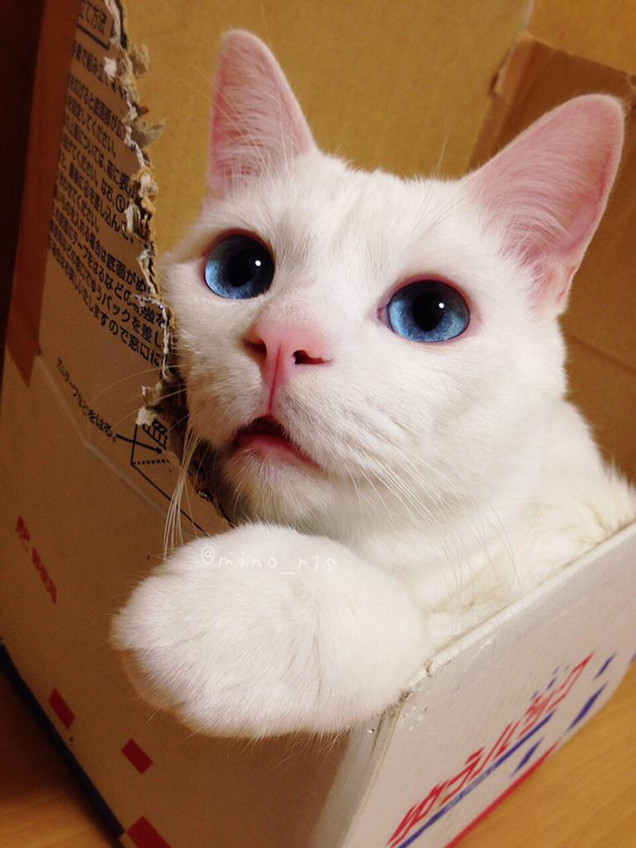

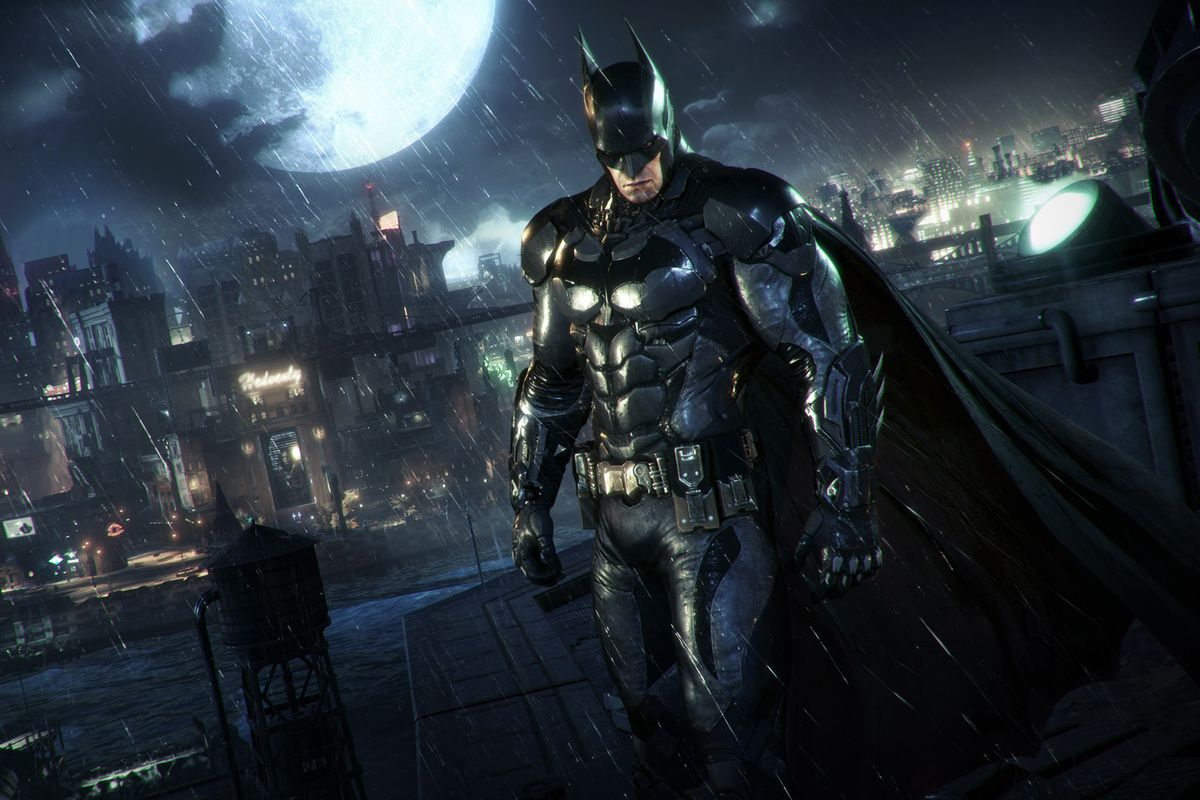

In [19]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [20]:
def preprocess_image(image_path):
    # Функція для відкриття, зміни розміру та форматування зображень у відповідні тензори
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Функція для перетворення тензора в дійсне зображення
    x = x.reshape((img_nrows, img_ncols, 3))
    # Видаляємо нуль-центр за допомогою середнього пікселя
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


In [21]:
# Матриця Грама тензора зображення (зовнішній добуток за особливостями)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

# "Втрата стилю" призначена для збереження
# стилю посилання на зображення у згенерованому зображенні.
# Вона базується на матрицях Грама (які захоплюють стиль) з
# карт особливостей зі стилю посилання на зображення
# та зі згенерованого зображення
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

# Допоміжна функція втрати
# призначена для збереження "контенту"
# базового зображення у згенерованому зображенні
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

# 3-я функція втрати, загальна варіація,
# призначена для збереження локальної узгодженості згенерованого зображення
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


In [22]:
# Створюємо модель VGG19, завантажену з попередньо навченими вагами ImageNet
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Отримуємо символьні виходи кожного "ключового" шару (ми дали їм унікальні імена).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Налаштовуємо модель, яка повертає значення активації для кожного шару в
# VGG19 (як словник).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


In [23]:
# Список шарів, які використовуються для втрати стилю.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# Шар, який використовується для втрати контенту.
content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    # Функція для обчислення загальної втрати
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Ініціалізація втрати
    loss = tf.zeros(shape=())

    # Додавання втрати контенту
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Додавання втрати стилю
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Додавання втрати загальної варіації
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


In [24]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [25]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

Iteration 100: loss=2863.40
Iteration 200: loss=2140.66
Iteration 300: loss=1842.91
Iteration 400: loss=1665.33
Iteration 500: loss=1541.39
Iteration 600: loss=1446.77
Iteration 700: loss=1372.57
Iteration 800: loss=1311.83
Iteration 900: loss=1262.43
Iteration 1000: loss=1220.89
Iteration 1100: loss=1184.64
Iteration 1200: loss=1153.52
Iteration 1300: loss=1126.00
Iteration 1400: loss=1101.74
Iteration 1500: loss=1080.49
Iteration 1600: loss=1061.60
Iteration 1700: loss=1044.87
Iteration 1800: loss=1029.78
Iteration 1900: loss=1016.15
Iteration 2000: loss=1003.71
Iteration 2100: loss=992.32
Iteration 2200: loss=981.86
Iteration 2300: loss=972.23
Iteration 2400: loss=963.38
Iteration 2500: loss=955.18
Iteration 2600: loss=947.58
Iteration 2700: loss=940.47
Iteration 2800: loss=933.87
Iteration 2900: loss=927.71
Iteration 3000: loss=921.93
Iteration 3100: loss=916.52
Iteration 3200: loss=911.47
Iteration 3300: loss=906.75
Iteration 3400: loss=902.31
Iteration 3500: loss=898.13
Iteration

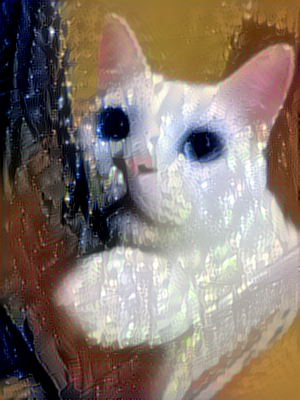

In [26]:
display(Image(result_prefix + "_at_iteration_4000.png"))